# Reproduction of grokking on a conv net for image classification

## Step 1: Produce dataset
I start by producing a simple algorithmic dataset, similar to the one in the core paper. The network will be trained to evaluate an expression of the type (a + b) mod p, where a and b are numbered inputs and p is a prime number.

In [13]:
# Imports
import os
import datetime
import random
import glob
import math
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from notebook import notebookapp
import datetime

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset


import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# Scikit-learn
from sklearn.model_selection import train_test_split

# Set seeds for reproducability
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Step 1: Create dataset

In [14]:
# Datasets
dataset = torchvision.datasets.MNIST(root='./data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)


def get_datasets(train_size=100, val_size=10, device='cpu'):
    """
    - train_frac: What fraction of the total amount of data should be train versus validation
    - number_occurence: Number of occurences for each number 0-9 in the total data
    """

    targets = dataset.targets.numpy()
    
    # Allocate memory for data subset
    train_idx = np.zeros((10, train_size))
    val_idx = np.zeros((10, val_size))
    
    # Loop over all 10 numbers in dataset
    for number in range(10):
        number_idx = np.where(targets==number)[0]
        random_selection = np.random.choice(number_idx, train_size + val_size, replace=False)
        
        mask = np.zeros(random_selection.size)
        mask[np.random.choice(np.arange(mask.size), train_size, replace=False)] = 1
        train_idx[number] = random_selection[mask.astype(bool)]
        val_idx[number] = random_selection[~mask.astype(bool)]
    
    train_idx = train_idx.flatten().astype(int)
    np.random.shuffle(train_idx)
    val_idx = val_idx.flatten().astype(int)
    np.random.shuffle(val_idx)
        
    # Use indices to retrieve train/val split
    X_train = dataset.data[train_idx][:, None, :, :].double().to(device)
    Y_train = dataset.targets[train_idx].long().to(device)
    X_val = dataset.data[val_idx][:, None, :, :].double().to(device)
    Y_val = dataset.targets[val_idx].long().to(device)
    return X_train, Y_train, X_val, Y_val

# Step 2: Define model

In [40]:
# Default network architecture
img_size = 28
n_channels = 1
num_classes = 10

# Conv layers
num_filters = np.array([8, 16])
filter_sizes = np.array([5, 5])
pool_sizes = np.array([2, 2])

# Fully connected layer
fc_layers = np.array([64, 32])


class NumberDetector(nn.Module):
    def __init__(self, device='cpu', init_weight_factor=1):
        super(NumberDetector, self).__init__()
        self.device = device
        
        
        # Add all conv layers in beginning
        self.conv_layers = []
        for i in range(num_filters.size):
            # Add conv
            if i == 0:
                self.conv_layers.append(nn.Conv2d(n_channels, num_filters[i], kernel_size=filter_sizes[i], padding=filter_sizes[i]//2))
            else:
                self.conv_layers.append(nn.Conv2d(num_filters[i-1], num_filters[i], kernel_size=filter_sizes[i], padding=filter_sizes[i]//2))

            # Add pool
            if pool_sizes[i] > 1:
                self.conv_layers.append(torch.nn.MaxPool2d(kernel_size=(pool_sizes[i], pool_sizes[i])))

            # Add relu
            self.conv_layers.append(nn.ReLU())    
        
        self.conv_seq = nn.Sequential(*self.conv_layers)

        
        # Add fully connected layers
        # First layer
        self.lin_input_size = int(num_filters[-1] * ( img_size / np.prod(pool_sizes) )**2)
        self.lin_layers = [nn.Linear(self.lin_input_size, fc_layers[0]), nn.ReLU()]
        
        # Intermediate layers
        if fc_layers.size >= 1:
            for i in range(fc_layers.size-1):
                self.lin_layers.append(nn.Linear(fc_layers[i], fc_layers[i+1]))
                self.lin_layers.append(nn.ReLU())
    
        # Final layer
        self.lin_layers.append(nn.Linear(fc_layers[-1], num_classes))
        self.lin_seq = nn.Sequential(*self.lin_layers)
        
        self.init_weights(init_weight_factor)

    
    def get_weight_norm(self):
        weights = []
        
        with torch.no_grad():
            for layer in self.conv_seq:
                if isinstance(layer, nn.Conv2d):
                    w = layer.weight.data.cpu().numpy()
                    n = w.size
                    avg = np.average(np.abs(w.flatten()))
                    weights.append((n, avg))
                    
                    
            for layer in self.lin_seq:
                if isinstance(layer, nn.Linear):
                    w = layer.weight.data.cpu().numpy()
                    n = w.size
                    avg = np.average(np.abs(w.flatten()))
                    weights.append((n, avg))
           
        n_weights = 0
        avg_sum = 0
        
        for (n, avg) in weights:
            n_weights += n
            avg_sum += avg
            
        return avg_sum / n_weights

        
        
    def init_weights(self, init_weight_factor):
        with torch.no_grad():
            for layer in self.conv_seq:
                if isinstance(layer, nn.Conv2d):
                    layer.weight.data = layer.weight.data * init_weight_factor
                    
            for layer in self.lin_seq:
                if isinstance(layer, nn.Linear):
                    layer.weight.data = layer.weight.data * init_weight_factor

            
    def forward(self, x):
        # Conv layers
        w = self.conv_seq(x)

        # Fully connected layer
        x = w.view(-1, self.lin_input_size)
        x = self.lin_seq(x)

        return x, w

# Step 3: Training the model

In [4]:
def per_number_loss(predictions, labels, loss_fn):
    loss = np.zeros(10)
    for number in range(10):
        idx = np.where(labels.cpu()==number)
        number_pred = predictions[idx]
        number_label = labels[idx]
                
        loss[number] = loss_fn(number_pred, number_label)
    return loss
        
def kernel_ex_loss(X, y, model, loss_fn):
    pass

In [5]:
# Try to "turn off" a specific kernel (zero out)
def ex_loss(data, label, model, loss_fn):

    ex_loss = []
    
    for layer in model.conv_seq:
        ex_loss_layer = []
        
        if isinstance(layer, nn.Conv2d):
            for i in range(len(layer._parameters['weight'])):
                with torch.no_grad():
                    # Zero out weights
                    layer_backup = layer._parameters['weight'][i].clone().detach()
                    layer._parameters['weight'][i] = torch.DoubleTensor(np.zeros((1, 1, 5, 5)))
                    
                    # Calculate exclussion loss
                    pred = model(data)[0]
                    loss = loss_fn(pred, label)
                    ex_loss_layer.append(loss)
                    
                    # Reset weights
                    layer._parameters['weight'][i] = layer_backup
            
            ex_loss.append(ex_loss_layer)
    
    return ex_loss

In [6]:
def train(run_name=datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")):
    # Random seeds for reproducability
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Init model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = NumberDetector(device=device, init_weight_factor=init_weight_factor).double()
    model.to(device)

    # Define optimizing process
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.98))
    loss_fn = torch.nn.CrossEntropyLoss()

    # Run formalities
    try:
        os.mkdir(save_root/run_name)
    except:
        print("Path already exists")
        
    save_dict = {'model':model.state_dict()}
    torch.save(save_dict, save_root/run_name/'init.pth')

    # Get data
    X_train, Y_train, X_val, Y_val = get_datasets(train_size, val_size, device=device)
    
    # Allocate lists for loss storage
    train_losses = []
    val_losses = []
    
    train_acc = []
    val_acc = []
    
    train_number_losses = np.zeros((10, num_epochs))
    val_number_losses = np.zeros((10, num_epochs))
    
    train_ex_losses = []
    val_ex_losses = []
    
    # Train over several epochs
    for epoch in range(num_epochs):
        # Calculate train and val loss
        train_pred = model(X_train)[0]
        train_loss = loss_fn(train_pred, Y_train.to(device))
        train_losses.append(train_loss.item())
        
        optimizer.zero_grad()
        train_loss.backward()
                
        val_pred = model(X_val)[0]
        val_loss = loss_fn(val_pred, Y_val.to(device))
        val_losses.append(val_loss.item())
        
        
        # Accuracy
        train_acc.append((np.argmax(train_pred.cpu().detach().numpy(), axis=1) == Y_train.cpu().numpy()).sum() / Y_train.size())
        val_acc.append((np.argmax(val_pred.cpu().detach().numpy(), axis=1) == Y_val.cpu().numpy()).sum() / Y_val.size())
    
        # Per number loss
        if calc_number_loss:
            train_number_losses[:, epoch] = per_number_loss(train_pred, Y_train, loss_fn)
            val_number_losses[:, epoch] = per_number_loss(val_pred, Y_val, loss_fn)
        
        # Exclussion loss
        if calc_kernel_ex_loss and (epoch%calc_ex_loss_every == 0):
            with torch.no_grad():
                train_ex_losses.append( ex_loss(X_train, Y_train, model, loss_fn) )
                val_ex_losses.append( ex_loss(X_val, Y_val, model, loss_fn) )
    
        
        # Print status
        if epoch%100 == 0: 
            #print(f"{epoch}_{np.log(train_loss.item()):.4f}_{np.log(val_loss.item()):.4f}")
            print(f"{epoch}_{train_acc[epoch]}_{val_acc[epoch]}")

        # Calc gradients and perform backprop
        optimizer.step()

        if (save_models) and (epoch%save_every == 0):

            save_dict = {
                'model': model.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'epoch': epoch,
            }
            torch.save(save_dict, save_root/run_name/f"{epoch}.pth")
            print(f"Saved model to {save_root/run_name/f'{epoch}.pth'}")

    save_dict = {
        'model': model.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'train_number_losses': train_number_losses,
        'val_number_losses': val_number_losses,
        'train_ex_losses': train_ex_losses,
        'val_ex_losses': val_ex_losses,
        'epoch': epoch,
    }

    torch.save(save_dict, save_root/run_name/f"final.pth")
    print(f"Saved model to {save_root/run_name/f'final.pth'}")

# Step 4: Experiment and analyse

In [153]:
# Model params
lr=1e-3

# Training params
num_epochs = 5000
save_models = True
save_every = 500
save_root = Path("checkpoints")

# Dataset params
train_size = 10  # per number
val_size = 30   # per number

calc_kernel_ex_loss = True
calc_ex_loss_every = 100
calc_number_loss = True

# Run training
train_sizes = [30]
weight_decays = [1e0]
init_weight_factor = 100
tag = "deep"

# Use this loop to recreate the same data as used in the report
for size in train_sizes:
    train_size = size
    for decay in weight_decays:
        weight_decay = decay
        
        exp_name = f"{tag}_{decay}decay_{size}examples"
        train(exp_name)

Adjust initial weights for conv layer
Adjust initial weights for conv layer
Adjust initial weights for linear layer
Adjust initial weights for linear layer
Adjust initial weights for linear layer
Path already exists
0_[0.10333333]_[0.13]
Saved model to checkpoints/deep_1.0decay_30examples/0.pth
100_[0.27]_[0.23]
200_[0.48666667]_[0.33]
300_[0.73]_[0.40333333]
400_[0.89666667]_[0.41666667]
500_[0.96]_[0.42666667]
Saved model to checkpoints/deep_1.0decay_30examples/500.pth
600_[0.99333333]_[0.44333333]
700_[0.99666667]_[0.44666667]
800_[1.]_[0.45]
900_[1.]_[0.45666667]
1000_[0.99666667]_[0.46]
Saved model to checkpoints/deep_1.0decay_30examples/1000.pth
1100_[1.]_[0.46666667]
1200_[1.]_[0.48]
1300_[1.]_[0.46666667]
1400_[1.]_[0.47333333]
1500_[1.]_[0.47333333]
Saved model to checkpoints/deep_1.0decay_30examples/1500.pth
1600_[1.]_[0.47333333]
1700_[1.]_[0.47333333]
1800_[1.]_[0.47333333]
1900_[1.]_[0.47333333]
2000_[1.]_[0.47333333]
Saved model to checkpoints/deep_1.0decay_30examples/200

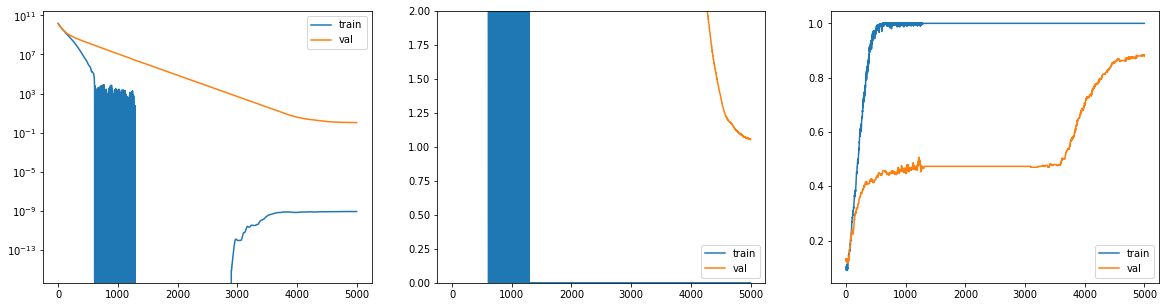

In [154]:
load_dict = torch.load(f"checkpoints/{exp_name}/final.pth")
   
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 5))
    
ax0.plot(load_dict['train_losses'], label='train')
ax0.plot(load_dict['val_losses'], label="val")
ax0.set_yscale('log')
ax0.legend()

ax1.plot(load_dict['train_losses'], label='train')
ax1.plot(load_dict['val_losses'], label="val")
ax1.set_ylim(0, 2)
ax1.legend()

ax2.plot(load_dict['train_acc'], label='train')
ax2.plot(load_dict['val_acc'], label="val")
ax2.legend()

## Effect of training set size


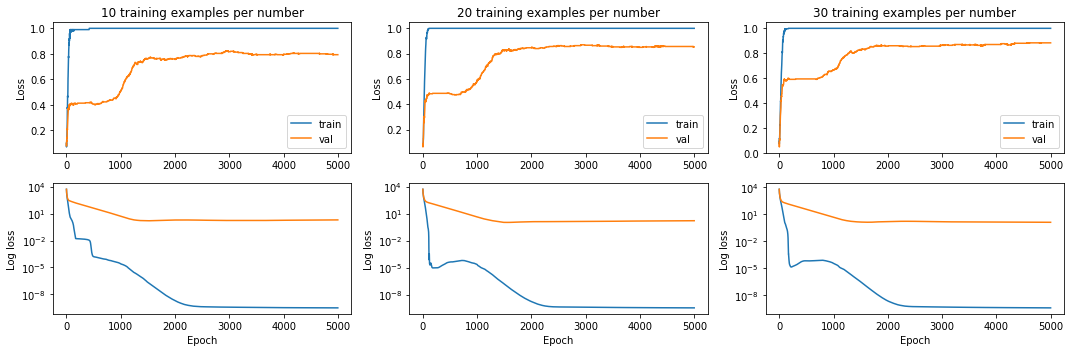

In [124]:
train_sizes = [10, 20, 30]
decay = 1e0
tag = "deep"

fig, axs = plt.subplots(2, len(train_sizes), figsize=(15, 5))

for i, size in enumerate(train_sizes):
    exp_name = f"{tag}_{decay}decay_{size}examples"
    load_dict = torch.load(f"checkpoints/{exp_name}/final.pth")

    axs[0][i].plot(load_dict['train_acc'], label='train')
    axs[0][i].plot(load_dict['val_acc'], label="val")

    axs[1][i].plot(load_dict['train_losses'], label='train')
    axs[1][i].plot(load_dict['val_losses'], label="val")
    axs[1][i].set_yscale('log')

    axs[0][i].set_title(f"{size} training examples per number")
    axs[0][i].set_ylabel("Loss")
    axs[1][i].set_ylabel("Log loss")
    axs[1][i].set_xlabel("Epoch")
    axs[0][i].legend()

plt.tight_layout()
plt.savefig("numbers_training_size.png")

## Effect of weight decay

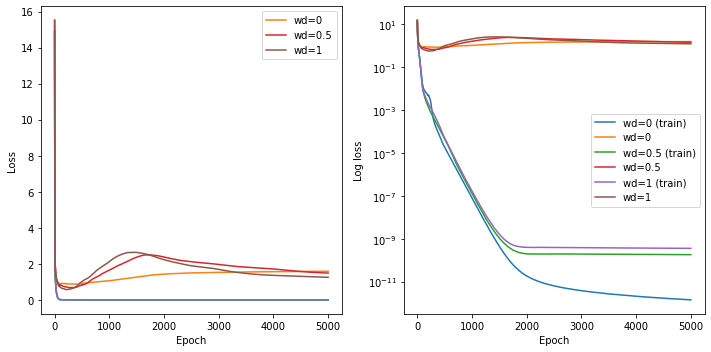

In [172]:
weight_decays = [0, 0.5, 1]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for decay in weight_decays:
    exp_name = f"small_{decay}decay_30examples"
    load_dict = torch.load(f"checkpoints/{exp_name}/final.pth")
   
    axs[0].plot(load_dict['train_losses'])
    axs[0].plot(load_dict['val_losses'], label=f"wd={decay}")
    
    axs[1].plot(load_dict['train_losses'], label=f"wd={decay} (train)")
    axs[1].plot(load_dict['val_losses'], label=f"wd={decay}")

axs[0].set_ylabel("Loss")
axs[0].set_xlabel("Epoch")
axs[0].legend()

axs[1].set_ylabel("Log loss")
axs[1].set_xlabel("Epoch")
axs[1].set_yscale('log')
axs[1].legend()    

plt.tight_layout()
plt.savefig("numbers_decay.png") 

## Visualize per-number errors

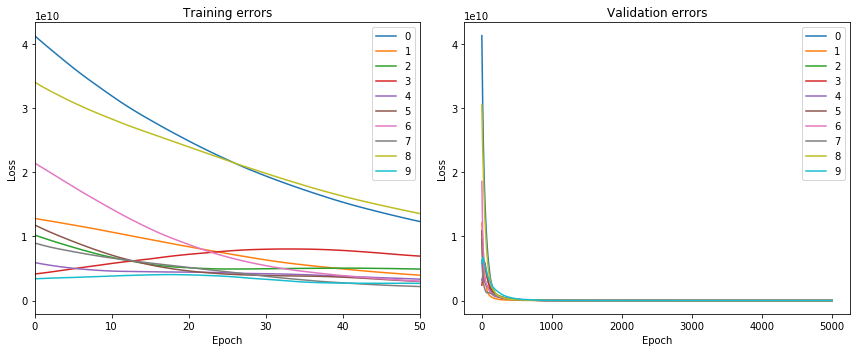

In [157]:
exp_name = f"deep_1.0decay_30examples"
load_dict = torch.load(f"checkpoints/{exp_name}/final.pth")

fig, ax = plt.subplots(1, 2,  figsize=(12, 5))

for number, losses in enumerate(load_dict['train_number_losses']):
    ax[0].set_title("Training errors")
    ax[0].plot(losses, label=str(number))
    ax[0].legend()
    ax[0].set_ylabel("Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].set_xlim(0, 50)

    
for number, losses in enumerate(load_dict['val_number_losses']):
    ax[1].set_title("Validation errors")
    ax[1].plot(losses, label=str(number))
    ax[1].legend()
    ax[1].set_ylabel("Loss")
    ax[1].set_xlabel("Epoch")

plt.tight_layout()
plt.savefig("numbers_label_errors")

## Plot exclusion losses

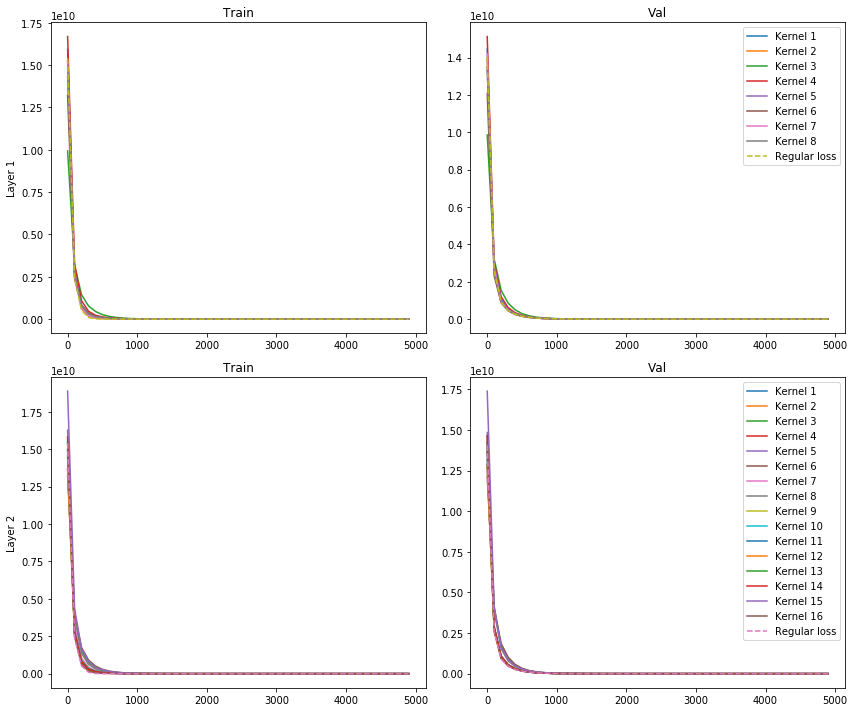

In [166]:
exp_name = f"deep_1.0decay_30examples"
load_dict = torch.load(f"checkpoints/{exp_name}/final.pth")

train_ex_losses = load_dict['train_ex_losses']
train_losses = load_dict['train_losses']
val_ex_losses = load_dict['val_ex_losses']
val_losses = load_dict['val_losses']

n_layers = len(train_ex_losses[0])
timesteps = np.arange(0, num_epochs, calc_ex_loss_every)

fig, ax = plt.subplots(n_layers, 2, figsize=(12, 5*n_layers))

for layer_idx in range(n_layers):
    layer_ax = ax[layer_idx] if n_layers > 1 else ax
    # Allocate memory 
    num_kernels = len(train_ex_losses[0][layer_idx])
    layer_losses = np.zeros((2, num_kernels, timesteps.size))

    # Gather data for each time step
    for t in range(timesteps.size):
        layer_losses[0, :, t] = train_ex_losses[t][layer_idx]
        layer_losses[1, :, t] = val_ex_losses[t][layer_idx]
        
    # For each kernel, plot its corresponding graph
    for i in range(num_kernels):
        layer_ax[0].plot(timesteps, layer_losses[0, i, :],  label=f"Kernel {i+1}")
        layer_ax[1].plot(timesteps, layer_losses[1, i, :],  label=f"Kernel {i+1}")
    
    layer_ax[0].plot(timesteps, train_losses[0:num_epochs:calc_ex_loss_every], linestyle='dashed', label='Regular loss')
    layer_ax[0].set_title("Train")
    
    layer_ax[1].plot(timesteps, val_losses[0:num_epochs:calc_ex_loss_every], linestyle='dashed', label='Regular loss')
    layer_ax[1].set_title("Val")
    
    layer_ax[1].legend()
    layer_ax[0].set_ylabel(f"Layer {layer_idx+1}")
    
plt.tight_layout()
plt.savefig("numbers_ex_loss.png")

## Visualize kernels

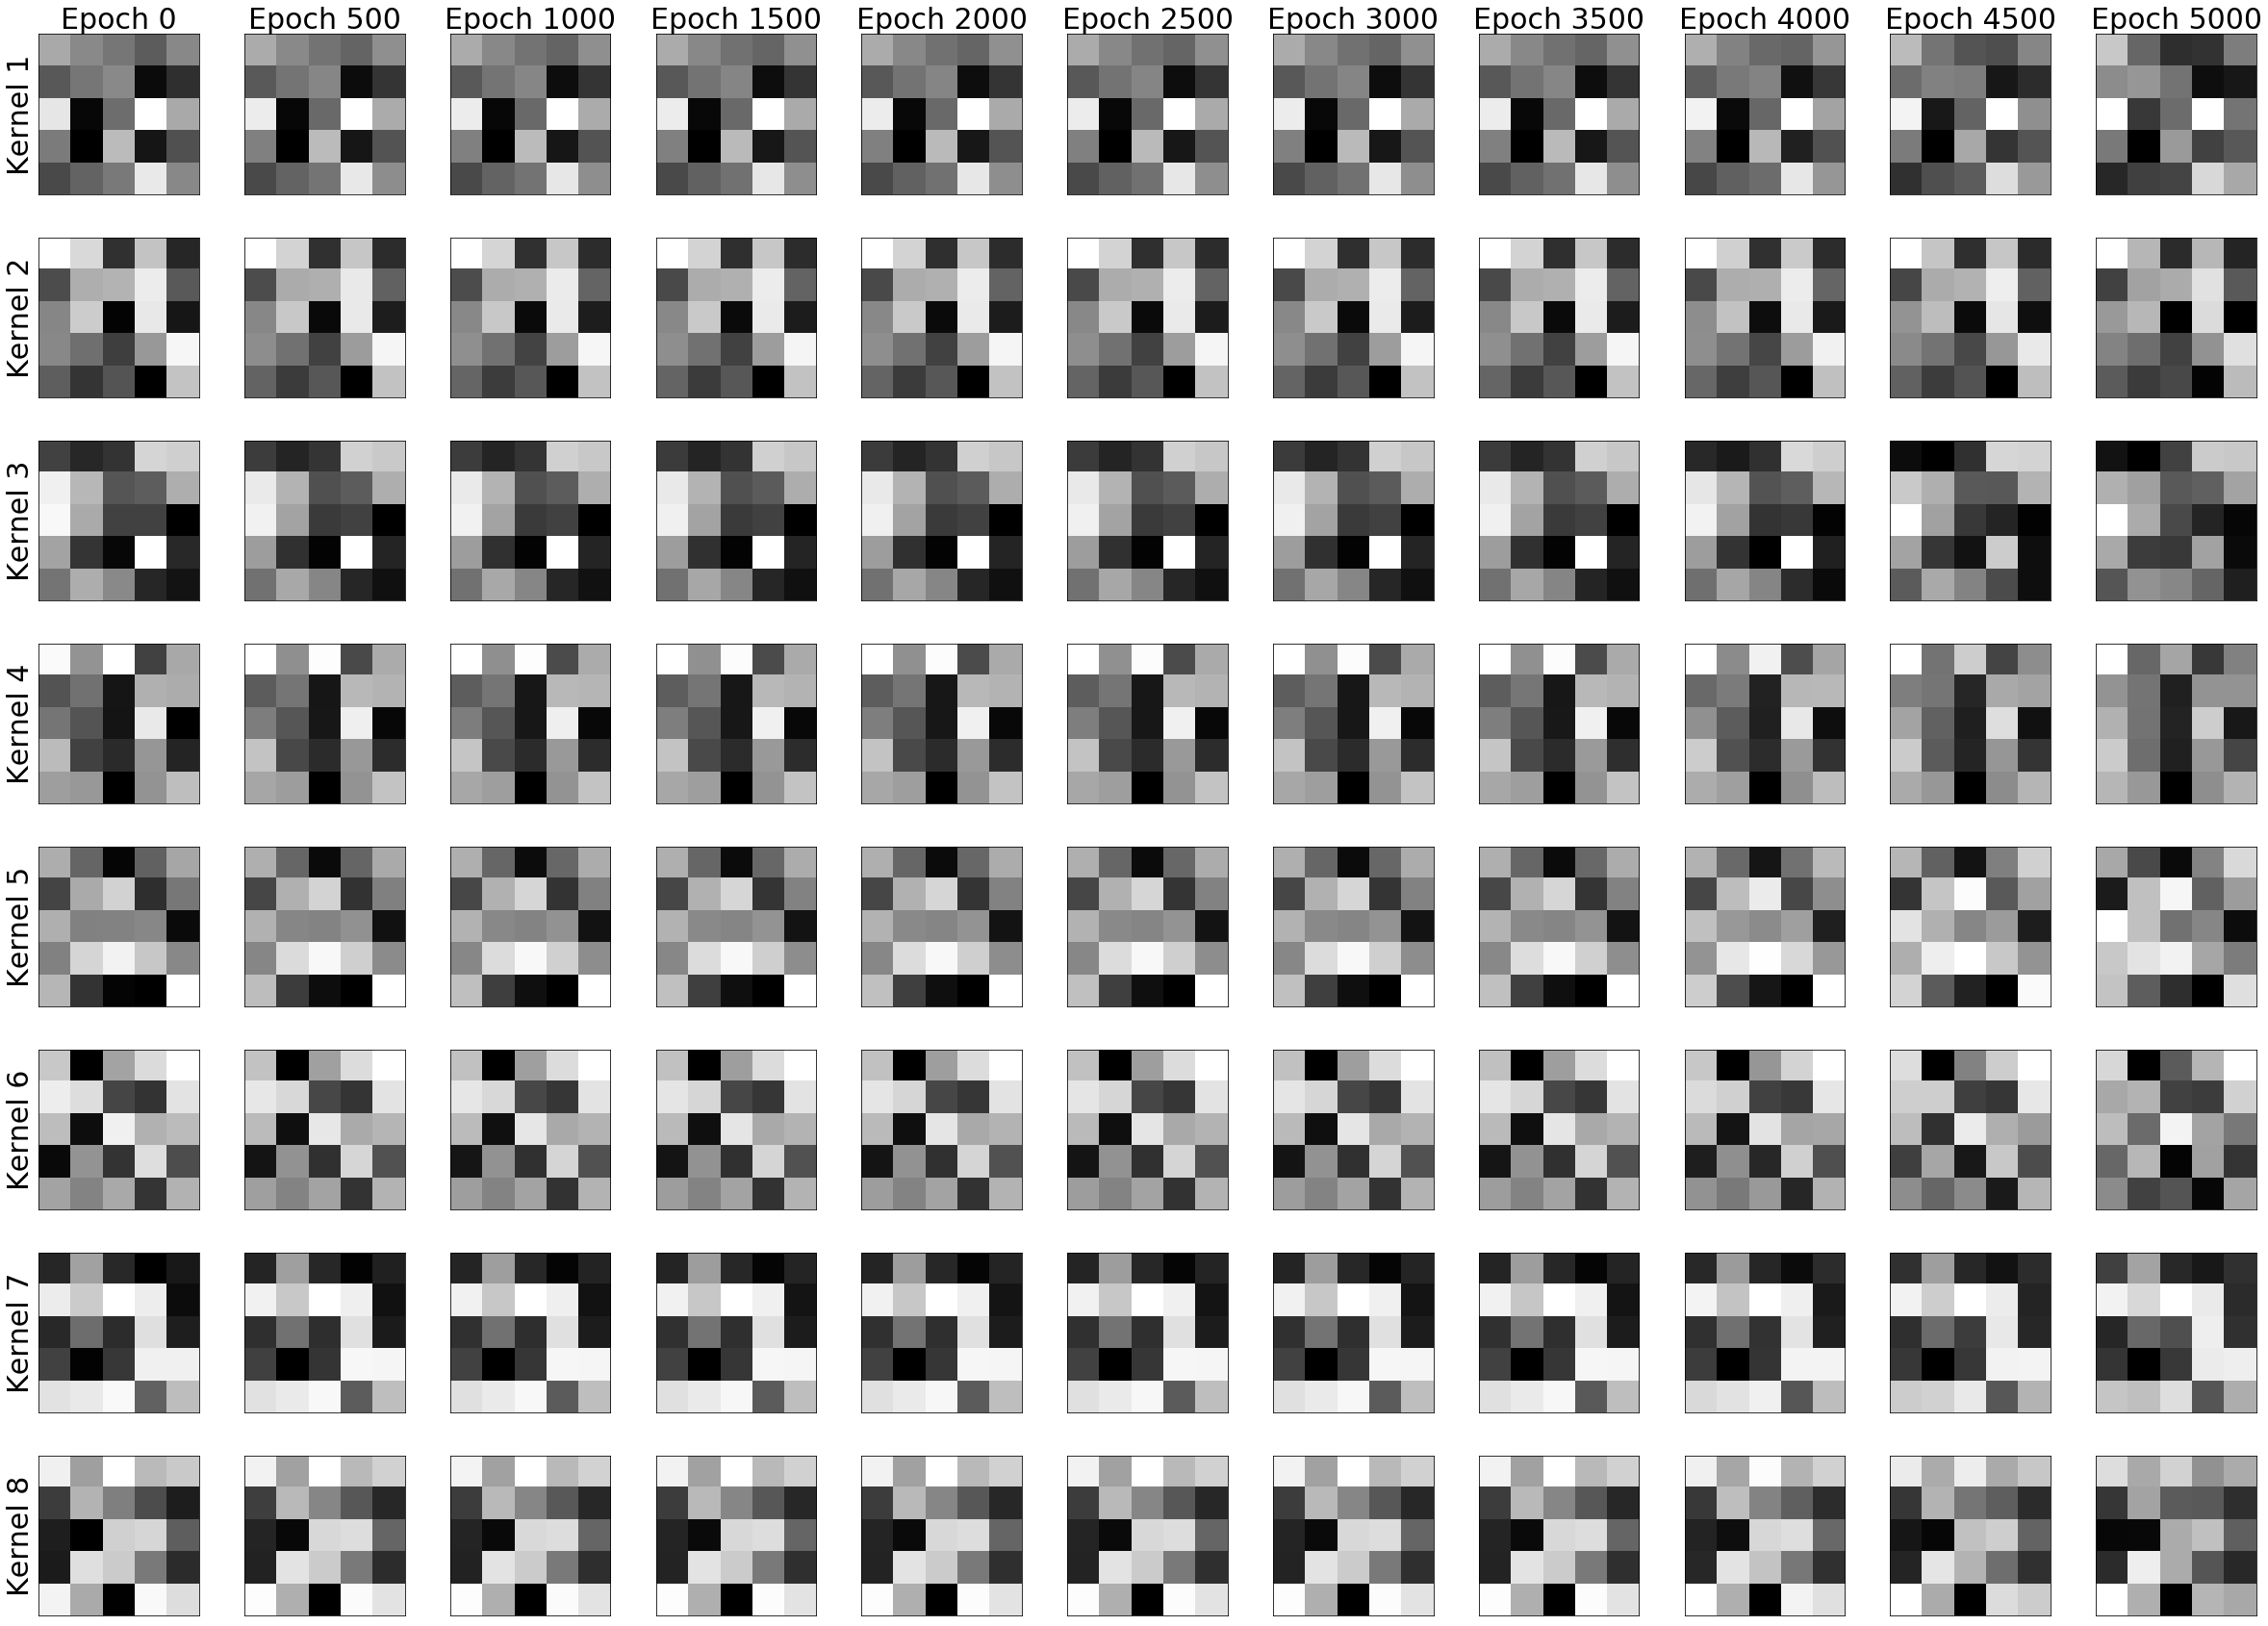

In [10]:
exp_name = f"deep_1.0decay_30examples"
cpts = glob.glob(f"checkpoints/{exp_name}/*")

kernels = {}
for cpt in cpts:
    if 'init' in cpt:
        continue
    elif 'final' in cpt:
        epoch = 5000
    else:
        epoch = int(os.path.basename(cpt).split(".")[0])

    load_dict = torch.load(cpt)
    kernels[epoch] = load_dict['model'][f'conv_seq.3.weight'][0]

n_cols = len(list(kernels.items()))
n_rows = len(list(kernels.items())[0][1])
fig, axs = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))

for i, epoch in enumerate(sorted(kernels)):
    for j, kernel in enumerate(kernels[epoch].squeeze()):
        ax = axs[j][i] 

        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(kernel.cpu(), cmap='gray')

        if i == 0:
            ax.set_ylabel(f"Kernel {j+1}", size=30)
        if j == 0:
            ax.set_title(f"Epoch {epoch}", size=30)
            
plt.tight_layout()
plt.savefig("numbers_kernels.png")

## Visualize activations from kernel 2

Adjust initial weights for conv layer
Adjust initial weights for conv layer
Adjust initial weights for linear layer
Adjust initial weights for linear layer
Adjust initial weights for linear layer
(7, 7, 1, 16)


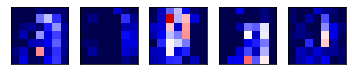

(7, 7, 1, 16)


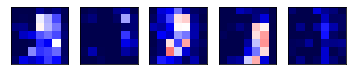

(7, 7, 1, 16)


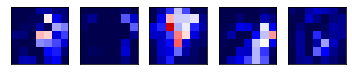

(7, 7, 1, 16)


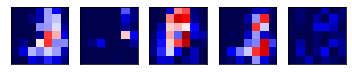

(7, 7, 1, 16)


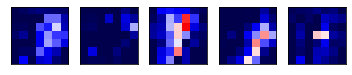

(7, 7, 1, 16)


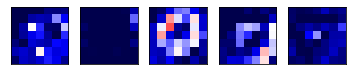

(7, 7, 1, 16)


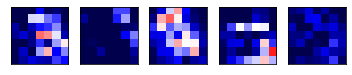

(7, 7, 1, 16)


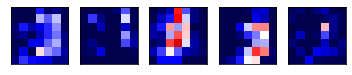

(7, 7, 1, 16)


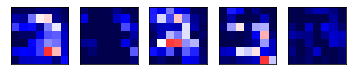

(7, 7, 1, 16)


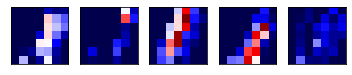

In [12]:
# Function from lab session in IMT 4392
def plot_conv_weights(weights):
    w=weights
    print(w.shape)
    w_min = np.min(w[:, :, :, 1])
    w_max = np.max(w)
    #shape =[filter_size,filter_size,num_channels,num_filters]
    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]
    # Number of grids to plot.
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(1, 5)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, 0, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

exp_name = f"deep_1.0decay_30examples"
load_dict = torch.load(f"checkpoints/{exp_name}/1500.pth")

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NumberDetector(device=device).double()
model.to(device)
model.load_state_dict(load_dict['model'])

# Get 1 example of each number
X_train, _, _, _ = get_datasets(train_size=1, device=device)

for i in range(len(X_train)):
    img = X_train[i].cpu().numpy().squeeze()
    
    activation = model(X_train[i].view(1,1,28,28))[1]
    plot_conv_weights((activation.permute(2,3,0,1).detach().cpu().numpy()))
    
    